In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

## Unbalanced emozioni

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

X = MinMaxScaler().fit_transform( df[numerical_attr_list])
ohenc = OneHotEncoder()
y = ohenc.fit_transform( (df["emotion"]=="angry").values.reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

weights = ((y_train[:, 1] == 1).astype(int) + 1)*8/2

In [4]:
from keras.layers import Input, Dense 
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy, BinaryAccuracy
from keras.models import Model

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu", name="dense_a")(input)
dense = Dense(256, activation="relu", name="dense_b")(dense)
dense = Dense(256, activation="relu", name="dense_c")(dense)
dense = Dense(256, activation="relu", name="dense_d")(dense)

# Now adds an output layer
# This will be removed when used in LstmEncoder
enc = Dense(y.shape[1], activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=enc, name="DenseNetwork")
model.compile(optimizer="adam",
            loss="binary_crossentropy",
            metrics= [BinaryCrossentropy(), BinaryAccuracy()],)
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 251)]             0         
                                                                 
 dense_a (Dense)             (None, 256)               64512     
                                                                 
 dense_b (Dense)             (None, 256)               65792     
                                                                 
 dense_c (Dense)             (None, 256)               65792     
                                                                 
 dense_d (Dense)             (None, 256)               65792     
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
Total params: 262,402
Trainable params: 262,402
Non-tr

In [5]:
history = model.fit(X_train, y_train, sample_weight=weights, epochs=70, batch_size=10, verbose=0)

Epoch 1/50
195/195 [==============================] - 3s 7ms/step - loss: 2.2126 - binary_crossentropy: 0.3884 - binary_accuracy: 0.8533
Epoch 2/50
195/195 [==============================] - 2s 8ms/step - loss: 1.9024 - binary_crossentropy: 0.3336 - binary_accuracy: 0.8811
Epoch 3/50
195/195 [==============================] - 2s 9ms/step - loss: 1.7149 - binary_crossentropy: 0.3030 - binary_accuracy: 0.8868
Epoch 4/50
195/195 [==============================] - 2s 8ms/step - loss: 1.7038 - binary_crossentropy: 0.2979 - binary_accuracy: 0.8914
Epoch 5/50
195/195 [==============================] - 2s 8ms/step - loss: 1.6356 - binary_crossentropy: 0.2859 - binary_accuracy: 0.8945
Epoch 6/50
195/195 [==============================] - 1s 6ms/step - loss: 1.6098 - binary_crossentropy: 0.2865 - binary_accuracy: 0.8986
Epoch 7/50
195/195 [==============================] - 2s 10ms/step - loss: 1.5995 - binary_crossentropy: 0.2804 - binary_accuracy: 0.9017
Epoch 8/50
195/195 [====================

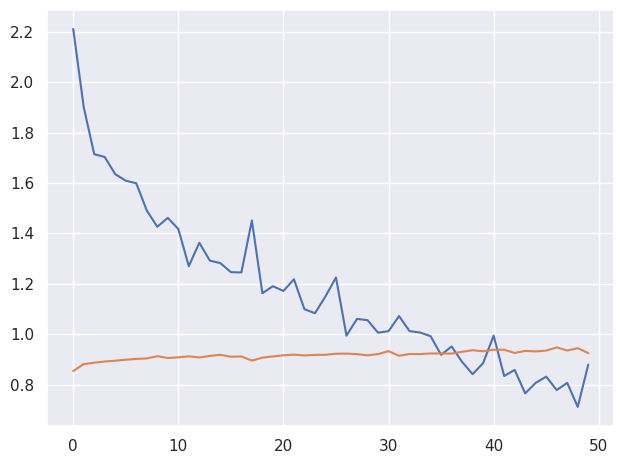

In [6]:
plt.plot(history.history["loss"])
plt.plot(history.history["binary_accuracy"])

4/4 [==============================] - 0s 3ms/step


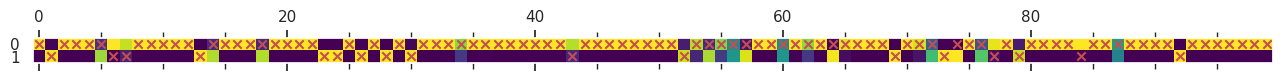

In [14]:
who = np.random.randint(len(y_test),size=100)

plt.matshow(model.predict(X_test[who,:]).T, cmap = "viridis")
plt.scatter( np.arange(len(who)), np.argmax(y_test[who], axis=-1), marker="x", color="r")
plt.grid("")

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(ohenc.inverse_transform(y_test), ohenc.inverse_transform(y_pred)))

16/16 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       405
        True       0.58      0.80      0.67        81

    accuracy                           0.87       486
   macro avg       0.77      0.84      0.79       486
weighted avg       0.89      0.87      0.88       486

